# overview
20230609

SarahFong

R2.3 comment - The homology and functional consistency of cross-species genes need to be supported by sufficient data, especially the homology and functional consistency of protein-coding genes in the collinear regions of human and bat genomes needs to be proved.

##### My plan - check for orthology of genes between humans and bats using pre-computed TOGA predictions from Hiller lab and Zoonomia consortium. 

    Inputs
        - Wei's data: gene names from hg38. Not sure why there is not transcript information for the transcripts. 
        - TOGA predictions - see README for full info - https://genome.senckenberg.de//download/TOGA/README.txt
            ./orthologsClassification.tsv  # classification of one:one, one:many, many:many orthologs predicted from TOGA using hg38 reference gene annotations and chain files between hg38 and Eptesicus_fuscus__big_brown_bat__eptFus1
            ./loss_summ_data.tsv  # classification of Intact, Partially Intact, Uncertain loss, Missing, Partially missing. 
        
## Here, I'm going to extract the genes from Wei's analysis, map those gene names to TOGA classifications (1:1, 1:many, or many:many), and assess how many orthologs map 1:1 between human and bat. 

### I will dev on EPTfus1
        

In [3]:
import config_readwrite as crw

import matplotlib.pyplot as plt
import os, sys
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# config 

In [4]:
cfn_file = os.path.join(os.getcwd(), "config.bats.ini")

config, cfn = crw.read(cfn_file)

# variables 

In [5]:
REFS = {"mm10": "mouse_mm10_reference",
        "hg38": "human_hg38_reference"}

TISSUES = ["panc", "kidn"]

# functions
## get transcripts w/ matched gene names

In [6]:
def getGenePred(gene_list, df, colname):
    """
    Get dataframe rows that contain the gene name. 
        Note - No transcript information, so we need to map gene names to transcripts
    
    input
        gene_list (list) - list of genes
        df (pd dataframe) - dataframe of TOGA predictions
        colname (str) - string name of the column in the TOGA dataframe
    
    method
        1. make empty collection dictionary
        2. per gene name, get the df rows that contain the gene name. 
            one gene can have many rows because TOGA will make predictions for multiple transcripts
        3. add gene name to that dataframe
        4. add to collection dictionary
        5. concatenate all the matching dataframes
    return 
        res (dataframe) - dataframe of the toga transcript predictions that match gene_list
    """
    print("merging gene names w/ TOGA transcripts")
    #1
    collection={}
    
    #2
    for gene in gene_names:
        test = df.loc[df[colname].str.contains(gene)].copy()
        
        #3 
        test["gene"] = gene
        
        #4
        collection[gene] = test
    #5
    res = pd.concat(collection.values())
    
    return res

## open differentially expressed gene file (one per tissue)

In [7]:
def openDEGDf(dif_exp_gene_file):
    print("open differentially expressed gene file")

    # open dataframe
    df = pd.read_csv(dif_exp_gene_file)

    ## set gene names
    gene_names = set(df["gene"])

    print(dif_exp_gene_file, "df size", df.shape, "n genes", len(gene_names))
    
    return df, gene_names

### N genes per sup table

- Fasting v. fed: 1871 genes in sup table 2
- Pancreas degs: 4757 genes in sup table 11
- Kidney degs: 4132 genes in sup table 5

## TOGA transcript predictions for gene names. 

Pred classes'

    # --- I: Intact
    # --- PI Partially Intact
    # --- UL: Uncertain Loss
    # --- M/PM: (Missing or Partially Missing)
    #        Partially Missing is a special subclass of Missing indicating that the overlapping chain only covers <50% of the gene's CDS
    # --- L: Lost
    # --- PG: Paralogous projection

In [8]:
def getEnstPerGene(res_pred):
    
    print("counting total ENST per gene")
    
    # total transcript per gene
    total_enst = res_pred.groupby(["gene"])["projection"].count().reset_index()
    
    # rename columns
    total_enst.columns=["gene", "n_totalenst"]
    
    return total_enst

def getClassCountPerGene(res_pred):
    """
    make table of class predictions per transcript per gene. 
    
    input
        res_pred (pd dataframe) - dataframe with gene, transcript, TOGA class predictions

    method
        1. count the predictions per gene for each class. 
        2. pivot to table, so that rows are genes, 
            columns are prediction classes, 
            and values are counts of the transcripts for that gene w that prediction class
        3. fill None w zeros, and make datatype int
        4. make column w/ intact + paritally intact transcripts summed together. 

    return
        class_table (df) - table with genes as rows, 
        ortholog prediction classes as columns, 
        and counts of the transcripts for each class. 
        
    """
    print("counting total ENST per gene AND class")
    
    # count the different predictions
    class_enst = res_pred.groupby(["gene", "class"])["projection"].count().reset_index()

    # pivot to table
    class_table = pd.pivot(class_enst, index = "gene", columns="class", values="projection").reset_index()

    # fill na w zeros
    class_table = class_table.fillna(0)

    # turn everything into int
    class_table.iloc[:,1:] = class_table.iloc[:,1:].astype(int)

    # sum intact annotations
    class_table["I/PI"] = class_table["I"] + class_table["PI"]

    return class_table

def getPercentTranscriptClass(class_table, total_enst):
    
    """
    turn class prediction counts into a percent of the total transcripts for each gene. 
    
    input
        class_table (pd dataframe) - table, rows = genes, cols = prediction classes, values = transcript count per class
        total_enst (pd dataframe) - dataframe, two columns, genes and count of total enst per gene
    method
        1. merge class table w/ total transcript df
        2. compute the percent of transcripts per gene in class prediction columns
        3. add back gene names as a column to percent table
    
    return
        percent (df) - table of percent of class predictions for all transcripts for each gene.
    """
    print("computing percent of gene transcripts in each class")

    #1 add total transcript counts to dataframe

    class_table = pd.merge(class_table, total_enst)


    #2 get percent of transcripts in each class

    percents = class_table.iloc[:,1:].div(class_table.n_totalenst, axis=0)

    #3 add back gene names
    percents = pd.merge(class_table["gene"], percents, left_index=True, right_index=True)
    
    return percents

## plotting functions

In [39]:
def plotPieChart(count_df, re_path, tissue, name, missing, ref):

    # count the number of genes w/ 0 intact/partially intact orthologs, and no ortholog predictions
    N_no, N_yes, N_missing = count_df['I'].iloc[0], count_df['I'].iloc[1], missing
    
    # make labels for pie chart
    labels = f"No (N={N_no}) intact/partially intact transcript", \
        f"Yes (N={N_yes}) intact/partially intact transcript", \
        f"Missing (N={N_missing} TOGA transcript predictions)"

    # plot pie chart
    fig1, ax = plt.subplots(figsize=(4, 4))
    
    sizes = [N_no, N_yes, N_missing]
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',
           startangle=0
           )
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')

    ax.set(title=f'{name} TOGA-{tissue} DEGs\n(ref:{ref})')
    
    # outfile name
    out = os.path.join(re_path, f"TOGA.{name}.{tissue}.{ref}.degs.pie.pdf")

    # save the chart
    plt.savefig(out, bbox_inches="tight")

def plotPieChartORTHO(class_count, re_path, tissue, name, missing, total, ref):
    print
    # count the number of genes w/ 0 intact/partially intact orthologs, and no ortholog predictions
    N_yes, N_missing = class_count.loc[class_count['orthology_class'] =='one2one',"q_gene"].iloc[0],missing
    N_no = total-(N_yes+N_missing)
    # make labels for pie chart
    labels = f"No one-to-one (N={N_no})", \
        f"Yes 1+ one-to-one (N={N_yes})", \
        f"Missing TOGA ortholog predictions (N={N_missing})"

    # plot pie chart
    fig1, ax = plt.subplots(figsize=(4, 4))
    
    sizes = [N_no, N_yes, N_missing]
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',
           startangle=0
           )
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')

    ax.set(title=f'{name} TOGA DEG orthologs\n(ref:{ref})')
    
    # outfile name
    out = os.path.join(re_path, f"TOGA.{name}.{ref}.degs.ortho.pie.pdf")

    # save the chart
    plt.savefig(out, bbox_inches="tight")


def plotEcdf(percents, re_path, tissue, name, ref):

    # count genes w/ zero, 100% intact/partially intact transcripts
    sero = percents.loc[percents["I/PI"] == 0].shape[0]
    um = percents.loc[percents["I/PI"] == 1].shape[0]

    # plot ecdf
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.ecdfplot(percents["I/PI"], stat="count")

    # set the title
    ax.set(title=f"{tissue} deg predicted in {name} TOGA\n(ref:{ref})",
           xlabel="percent of I/PI transcripts per gene",
           ylabel="N genes (cumulative)")

    # plot n genes with zero ortholog predictions
    ax.axhline(sero, ls="--", color='k')

    # add text
    ax.text(1.1, sero,
            f'n={sero} ({round(sero/percents.shape[0]*100, 0)}%) genes\nwith zero intact/partially intact\northolog transcript predictions')

    # plot n genes w/ 100% intact transcript predictions
    ax.axhline(percents.shape[0] - um, ls="--")

    # add text
    ax.text(
        1.1, um, f'n={um} ({round(um/percents.shape[0]*100, 0)}%) genes\nwith 100% intact/partially intact\northolog transcript predictions')

    
    out = os.path.join(re_path, f"{tissue}_gene_transcript_{name}.{ref}-ref.pdf")
    plt.savefig(out, bbox_inches='tight')

## one2one orthologs 

In [40]:
def getOne2OneCounts(class_file, gene_names, path, tissue, ref, bat_species, missing):
    
    print("finding one2one orthologs")
    # open the one2one classification file
    class_df = pd.read_csv(class_file, sep="\t")

    # make file merging gene names w/ n transcript ortholog classifications
    GENE_N_TRNSCRPT = os.path.join(path, f"{bat_species}.TOGA.ortho.transcripts.{tissue}_deg.{ref}-ref.tsv")

    if os.path.exists(GENE_N_TRNSCRPT) is False:

        # get all transcript predictions for DEG gene_names list
        # takes 1 minute
        res = getGenePred(gene_names, class_df, "t_transcript")

        # save the file
        res.to_csv(GENE_N_TRNSCRPT, sep="\t", index=False)

        # write to config
        config[section][f"{tissue}_deg_ortho"]=GENE_N_TRNSCRPT
        crw.write(config, cfn)

    else:
        res = pd.read_csv(GENE_N_TRNSCRPT, sep="\t")

    """
        7491 TOGA transcripts for 1871 genes from sup table 2 (fasting v. fed)
        16751 TOGA transcripts for 4757 deg Panc genes from sup table 5
        16751 TOGA transcripts for 4132 deg kidney genes from sup table 5
    """
    # count instances of ortho_class predictions (one2one, many2many, etc. )
    print(list(res))
    test = res[["gene", "orthology_class", "q_gene"]].drop_duplicates()
    
    one2one_genes = set(test.loc[test["orthology_class"]=="one2one", "gene"])
    noone2one_genes = set(test["gene"]).difference(one2one_genes)
    print(len(one2one_genes), len(noone2one_genes))
    orthoclass = test.groupby(["gene", "orthology_class"])["q_gene"].count().reset_index()

    class_count = orthoclass.groupby("orthology_class").count().reset_index()
    
    print(class_count,"\n")

    
    print(len(set(res["gene"])),"\n")
    
    total = len(gene_names)
    name = bat_species+"."+tissue
    print("plot ortho pie chart")
    plotPieChartORTHO(class_count, path, tissue, name, missing, total, ref)

    out = os.path.join(path, name+".no.one2one.txt")
    
    print("writing", out)
    # write no ortholog genes
    with open(out, "w") as writer:
        for i in noone2one_genes:
            writer.write(f"{i}\n")
    writer.close
    """
    ## orthologs? 
    - 98% of genes are eptFus1 orthologs (4650/4757)
    - 98% of orthologs are 1:1 (4547/4650)

    ## inspect genes w/ one2one annotations - they can still have many2many annotations
    """


## mouse human gene name mapping

In [13]:
def downloadHttp(http_address, local_path):

     # get the species
    file_name = http_address.split("/")[-1] 
    
    # file to write (in data file)
    local_file = os.path.join(local_path, file_name)

    if os.path.exists(local_file) is False:
        print("download", file_name)
        os.system(f"wget {http_address} \
        --no-check-certificate \
        && mv {file_name} {local_file}")  # download and rewrite filename w/ species
        
    else:
        print('already downloaded', file_name)

    return local_file

In [14]:
PATH = config["local"]['path']
JACKSON_HTTP="http://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt"

local_file = downloadHttp(JACKSON_HTTP, PATH)

d = pd.read_csv(local_file, sep='\t')
print(d.shape)

# keep only key, organism, and gene name info
d = d[['DB Class Key',
 'Common Organism Name',
 'Symbol']].drop_duplicates()

# split into human and mouse dataframes 
hu = d.loc[d['Common Organism Name']=="human"]
ms = d.loc[d['Common Organism Name']!="human"]
ms = ms.rename(columns = {"Symbol": "ms_Symbol"}) # rename mouse symbol

# merge human and mouse data back together. 
d = pd.merge(hu[['DB Class Key','Symbol']], ms[['DB Class Key','ms_Symbol']], how="left", on="DB Class Key")

already downloaded HOM_MouseHumanSequence.rpt
(46438, 13)


In [16]:
def getMouseGeneNames(gene_names, path):

    JACKSON_HTTP = "http://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt"

    local_file = downloadHttp(JACKSON_HTTP, PATH)

    d = pd.read_csv(local_file, sep='\t')
    print(d.shape)

    # keep only key, organism, and gene name info
    d = d[['DB Class Key',
           'Common Organism Name',
           'Symbol']].drop_duplicates()

    # split into human and mouse dataframes
    hu = d.loc[d['Common Organism Name'] == "human"]
    ms = d.loc[d['Common Organism Name'] != "human"]
    ms = ms.rename(columns={"Symbol": "ms_Symbol"})  # rename mouse symbol

    # merge human and mouse data back together.
    d = pd.merge(hu[['DB Class Key', 'Symbol']], ms[[
                 'DB Class Key', 'ms_Symbol']], how="left", on="DB Class Key")

    mouse_gene_names = list(d.loc[d["Symbol"].isin(gene_names), "ms_Symbol"])

    return mouse_gene_names

# Main - intact/partially intact transcripts

mouse_mm10_reference panc
open differentially expressed gene file
/wynton/home/ahituv/fongsl/other_analyses/for-wei_bats/data/supp/supp.table11.csv df size (20535, 7) n genes 4757
already downloaded HOM_MouseHumanSequence.rpt
(46438, 13)
human_hg38_reference panc
open differentially expressed gene file
/wynton/home/ahituv/fongsl/other_analyses/for-wei_bats/data/supp/supp.table11.csv df size (20535, 7) n genes 4757
/wynton/home/ahituv/fongsl/other_analyses/for-wei_bats/results/EPT.PRED.panc.human_hg38_reference-ref.deg.TOGA.class.tsv
(57434, 5) 4650
counting total ENST per gene
counting total ENST per gene AND class
computing percent of gene transcripts in each class
/wynton/home/ahituv/fongsl/other_analyses/for-wei_bats/results/ART.PRED.panc.human_hg38_reference-ref.deg.TOGA.class.tsv
(57680, 5) 4650
counting total ENST per gene
counting total ENST per gene AND class
computing percent of gene transcripts in each class
finding one2one orthologs
['t_gene', 't_transcript', 'q_gene', 'q_tr

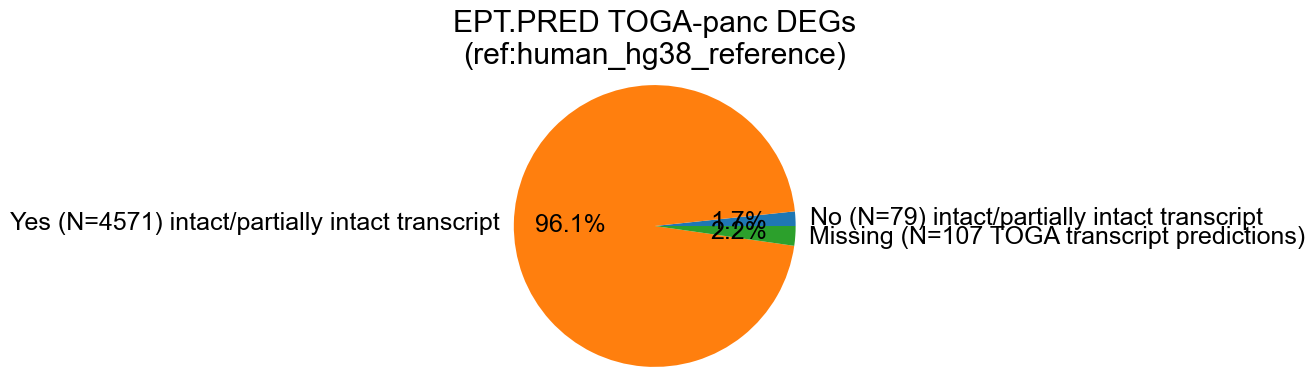

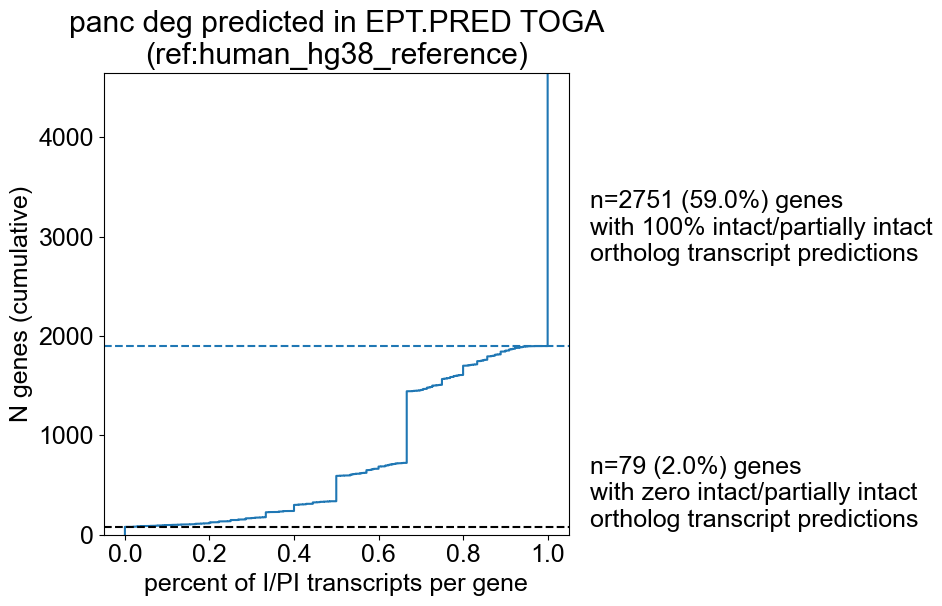

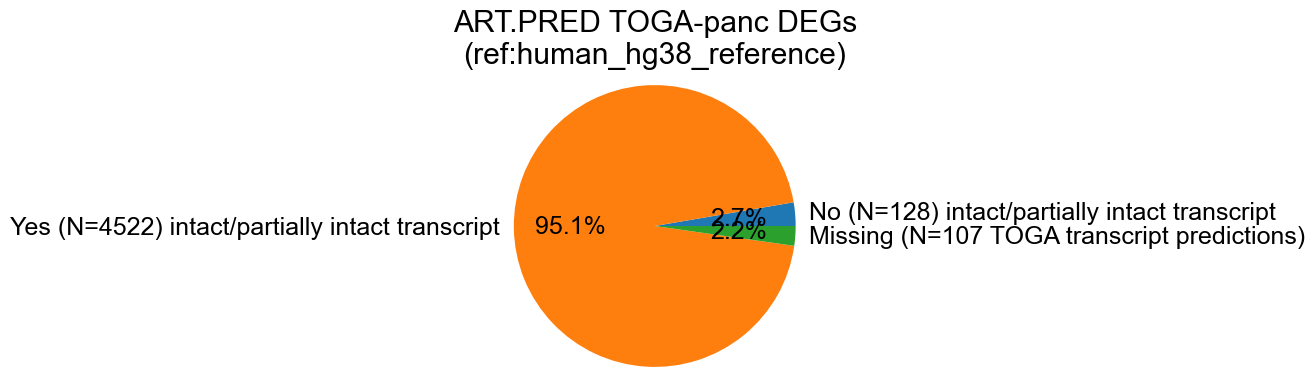

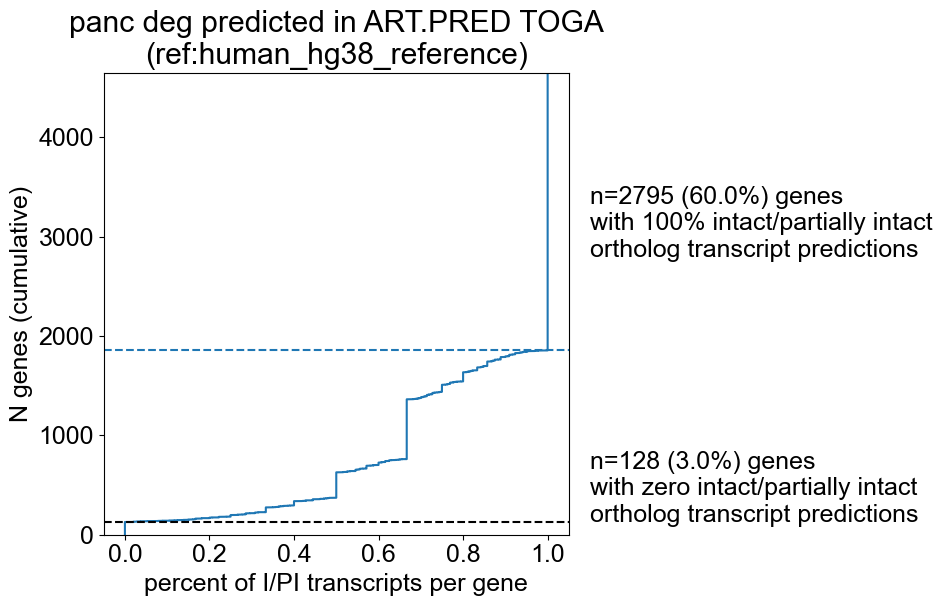

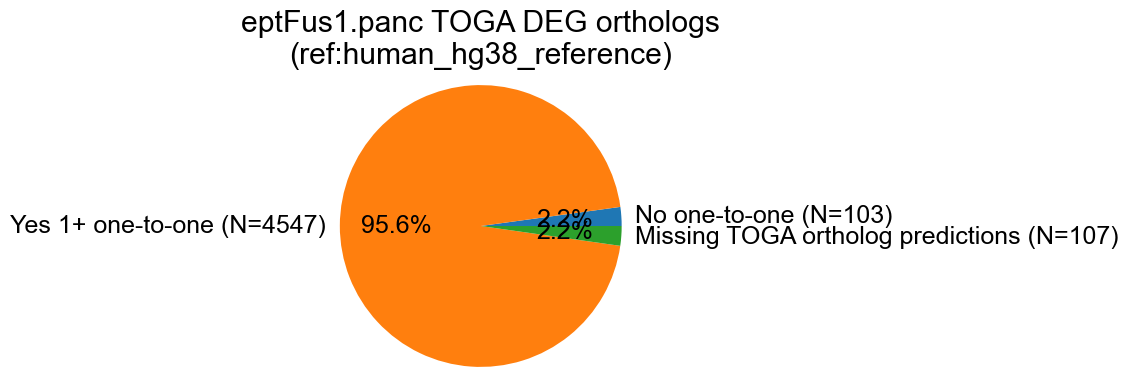

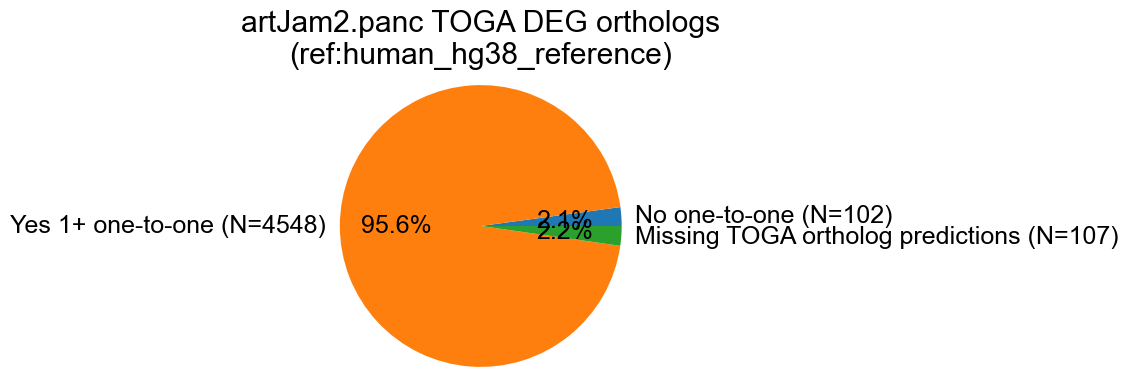

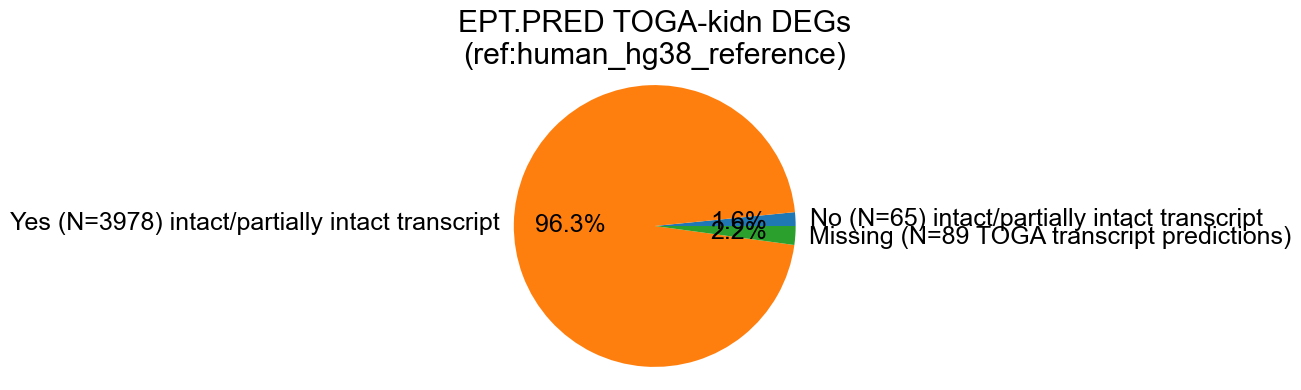

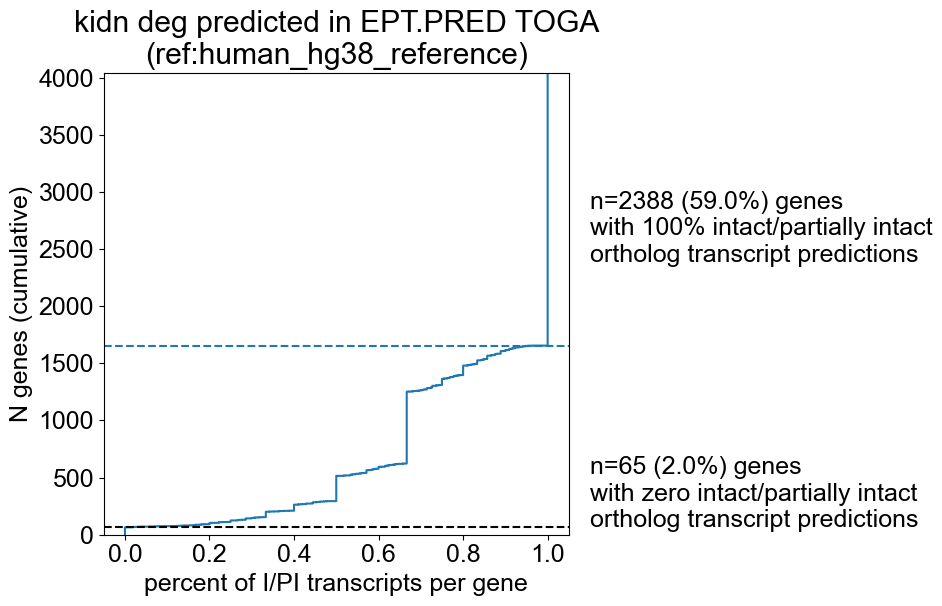

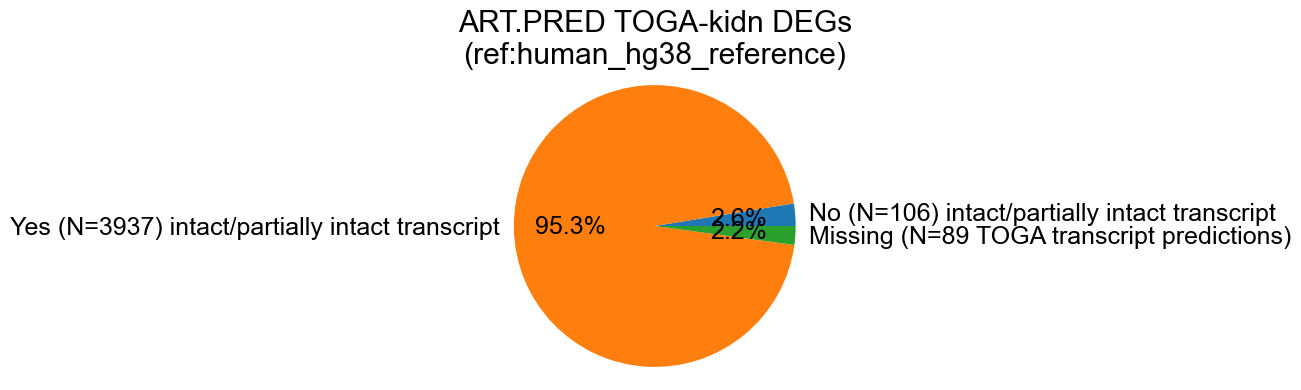

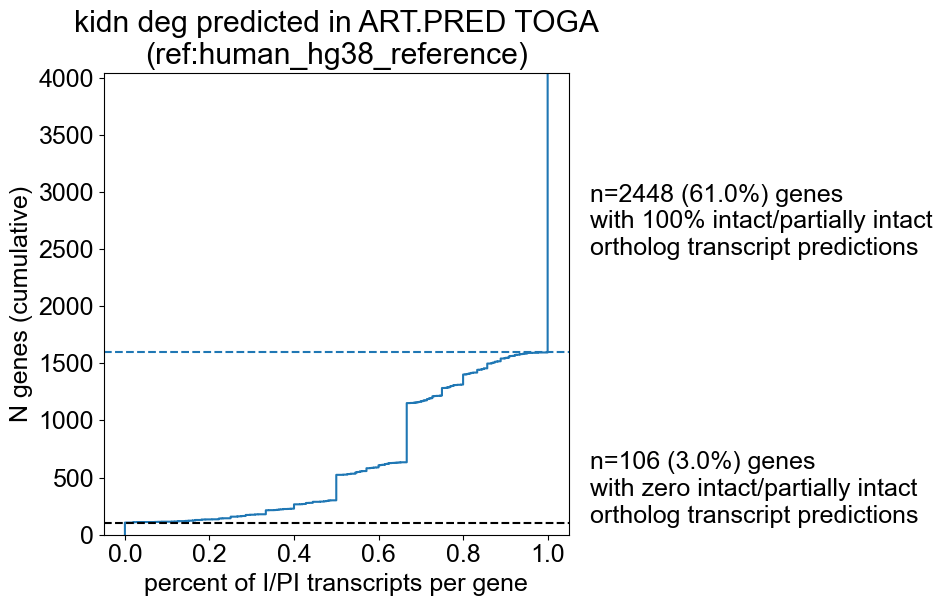

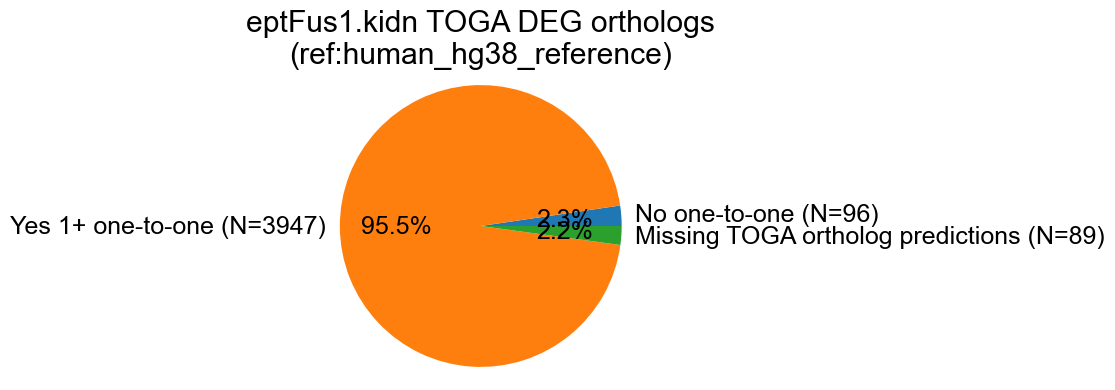

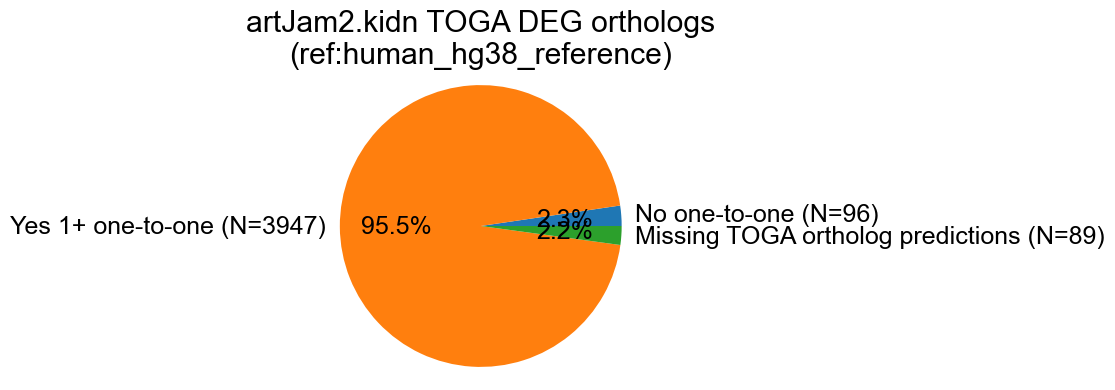

In [41]:
for TISSUE in TISSUES:
    for SPECIES, REF in REFS.items():
        print(REF, TISSUE)

        ###
        # load config
        ###

        section = f"local_toga-{REF}"

        PATH = config["local"]['path_toga']
        RE = config["local"]["results"]

        EPT_PRED = config[section][f"eptfus1.loss_summ_data.tsv.gz"]
        ART_PRED = config[section][f"hlartjam2.loss_summ_data.tsv.gz"]

        EPT_CLASS = config[section][f"eptfus1.orthologsclassification.tsv.gz"]
        ART_CLASS = config[section][f"hlartjam2.orthologsclassification.tsv.gz"]

        DEG = config["wei_supp"][f"{TISSUE}_deg"]

        crw.write(config, cfn)

        ###
        # intact/partially intact transcripts
        ###

        # open the differentially expressed genes, get gene names
        df, gene_names = openDEGDf(DEG)

        if SPECIES == "mm10":
            gene_names = getMouseGeneNames(gene_names, PATH)
            continue

        species_dict = {
            "EPT.PRED": EPT_PRED,
            "ART.PRED": ART_PRED
        }

        results = {}

        # make sure you save
        for name, filename in species_dict.items():

            OUT = os.path.join(
                RE, f"{name}.{TISSUE}.{REF}-ref.deg.TOGA.class.tsv")
            print(OUT)

            ### PROBLEM HERE? ###

            # open toga classifications.
            pred = pd.read_csv(filename, sep='\t', header=None, names=[
                               "projection", "transcript", "class"])

            if os.path.exists(OUT) is False:

                # subset the predictions for JUST the genes in Wei's paper.
                # do this once. Takes 4 minutes.
                res_pred = getGenePred(gene_names, pred, "transcript")
                res_pred.to_csv(OUT, sep="\t", index=False)

                # write to config
                config[section][f"{TISSUE}_deg_ortho_{name}"] = OUT
                crw.write(config, cfn)
            else:
                res_pred = pd.read_csv(OUT, sep='\t')
            res_pred["species"] = name

            print(res_pred.shape, len(set(res_pred["gene"])))

            # compute missing genes (not predicted in TOGA?)
            missing = len(gene_names) - len(set(res_pred["gene"]))

            # get counts

            # total enst per gene
            total_enst = getEnstPerGene(res_pred)

            # class enst per gene
            class_enst = getClassCountPerGene(res_pred)

            # percent class enst per gene
            percents = getPercentTranscriptClass(class_enst, total_enst)

            # add to results
            results[name] = [percents, class_enst, total_enst]

            # get the percent w/ zero orthologs
            percents["ortholog"] = '1+ orthologs'
            percents.loc[percents["I/PI"] == 0, "ortholog"] = "0 ortholog"

            count_df = percents.groupby(["ortholog"])[
                "I"].count().reset_index()
            plotPieChart(count_df, RE, TISSUE, name, missing, REF)

            # plot how many genes have 0 intact transcripts or 100% as ECDF
            plotEcdf(percents, RE, TISSUE, name, REF)

    # Main - one2one orthologs

    # Brownbat - one2one or one2many genes in TOGA predictions?
    getOne2OneCounts(EPT_CLASS, gene_names, PATH, TISSUE, REF, "eptFus1",missing)

    # fruigivorous bat
    getOne2OneCounts(ART_CLASS, gene_names, PATH, TISSUE, REF, "artJam2",missing)

In [1]:
43+69+80+4547+148

4887